## Tasks
We define the following quantities:
 * $P_\infty$ the probability that a node belongs to the giant component. This is the size of the largest component divided by the number of nodes
 * $S$ the average size of the components without the largest one

Start from the following networks:
 * ER, with $\langle k \rangle = 2$, $N=1000$
 * BE, with $m=2$, $N=1000$
 * the euflight data

Choose at least 4 different centrality measures (degree and betweennes should be included) measure and plot $P_\infty$ and $S$ as fucntion of the fraction of nodes removed. Remove nodes by ascending and descending centrality order. 


In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Barabási-Albert network
N = 1000  # Number of nodes
m = 2     # Number of edges to attach from a new node to existing nodes

# Create BA network
G = nx.barabasi_albert_graph(N, m)

print(f"BA Network created:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.3f}")

BA Network created:
  Nodes: 1000
  Edges: 1996
  Average degree: 3.992


In [6]:
# 1. DEGREE CENTRALITY
# Measures: Number of connections each node has
degree_centrality = nx.degree_centrality(G)

# 2. BETWEENNESS CENTRALITY  
# Measures: How often a node lies on shortest paths between other nodes
betweenness_centrality = nx.betweenness_centrality(G)

# 3. CLOSENESS CENTRALITY
# Measures: How close a node is to all other nodes (inverse of average distance)
closeness_centrality = nx.closeness_centrality(G)

# 4. EIGENVECTOR CENTRALITY
# Measures: Importance based on connections to other important nodes
eigenvector_centrality = nx.eigenvector_centrality(G)


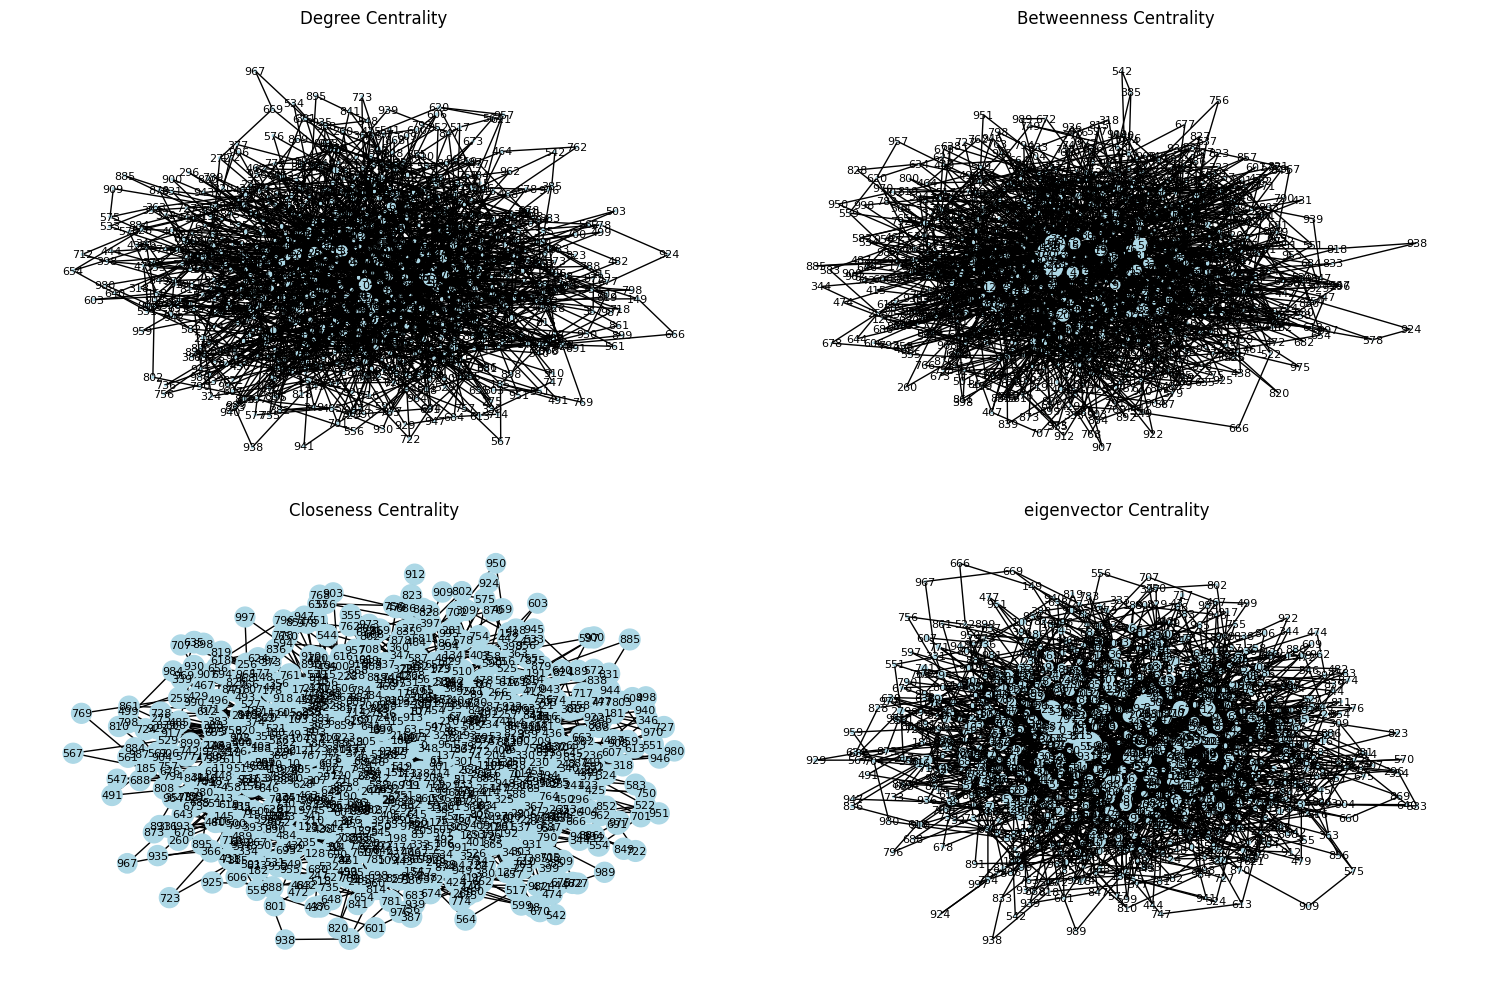

In [7]:
# Visualize the network with node sizes proportional to centrality
plt.figure(figsize=(15, 10))

centralities = [
    (degree_centrality, "Degree Centrality"),
    (betweenness_centrality, "Betweenness Centrality"), 
    (closeness_centrality, "Closeness Centrality"),
    (eigenvector_centrality, "eigenvector Centrality")
]

for i, (centrality_dict, title) in enumerate(centralities, 1):
    plt.subplot(2, 2, i)
    pos = nx.spring_layout(G)
    
    # Node sizes proportional to centrality
    node_sizes = [centrality_dict[node] * 1000 for node in G.nodes()]
    
    nx.draw(G, pos, 
            node_size=node_sizes,
            node_color='lightblue',
            with_labels=True,
            font_size=8)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
def calculate_P_infinity(G):
    """Calculate P∞ - size of largest component / total nodes"""
    if G.number_of_nodes() == 0:
        return 0
    
    # Find all connected components
    components = list(nx.connected_components(G))
    if not components:
        return 0
    
    # Size of largest component
    largest_component_size = max(len(comp) for comp in components)
    return largest_component_size / G.number_of_nodes()

def calculate_S(G):
    """Calculate S - average size of components excluding the largest one"""
    if G.number_of_nodes() == 0:
        return 0
    
    # Find all connected components
    components = list(nx.connected_components(G))
    if len(components) <= 1:
        return 0  # No components to average (or only one component)
    
    # Sort components by size
    component_sizes = sorted([len(comp) for comp in components], reverse=True)
    
    # Exclude the largest component and average the rest
    smaller_components = component_sizes[1:]
    return np.mean(smaller_components) if smaller_components else 0

def remove_nodes_by_centrality(G, centrality_dict, ascending=True):
    """
    Remove nodes based on centrality measure
    ascending=True: remove least central nodes first
    ascending=False: remove most central nodes first
    """
    # Sort nodes by centrality
    nodes_sorted = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=not ascending)
    
    # Extract just the node IDs
    removal_order = [node for node, centrality in nodes_sorted]
    
    # Track results
    fractions_removed = []
    P_infinity_values = []
    S_values = []
    
    # Create a copy to work with
    G_working = G.copy()
    
    # Remove nodes in steps (e.g., every 1% of nodes)
    step_size = max(1, N // 100)  # Remove 1% at a time
    
    for i in range(0, N, step_size):
        if i == 0:
            # Initial state (no nodes removed yet)
            fraction_removed = 0.0
        else:
            # Remove the next batch of nodes
            nodes_to_remove = removal_order[:i]
            G_working.remove_nodes_from(nodes_to_remove)
            fraction_removed = i / N
        
        # Calculate P∞ and S
        P_inf = calculate_P_infinity(G_working)
        S_avg = calculate_S(G_working)
        
        # Store results
        fractions_removed.append(fraction_removed)
        P_infinity_values.append(P_inf)
        S_values.append(S_avg)
        
        # Stop if network is completely disconnected
        if G_working.number_of_nodes() == 0:
            break
    
    return fractions_removed, P_infinity_values, S_values

In [9]:
# Remove nodes by degree centrality (ascending = least central first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, degree_centrality, ascending=True)

# Remove nodes by degree centrality (descending = most central first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, degree_centrality, ascending=False)

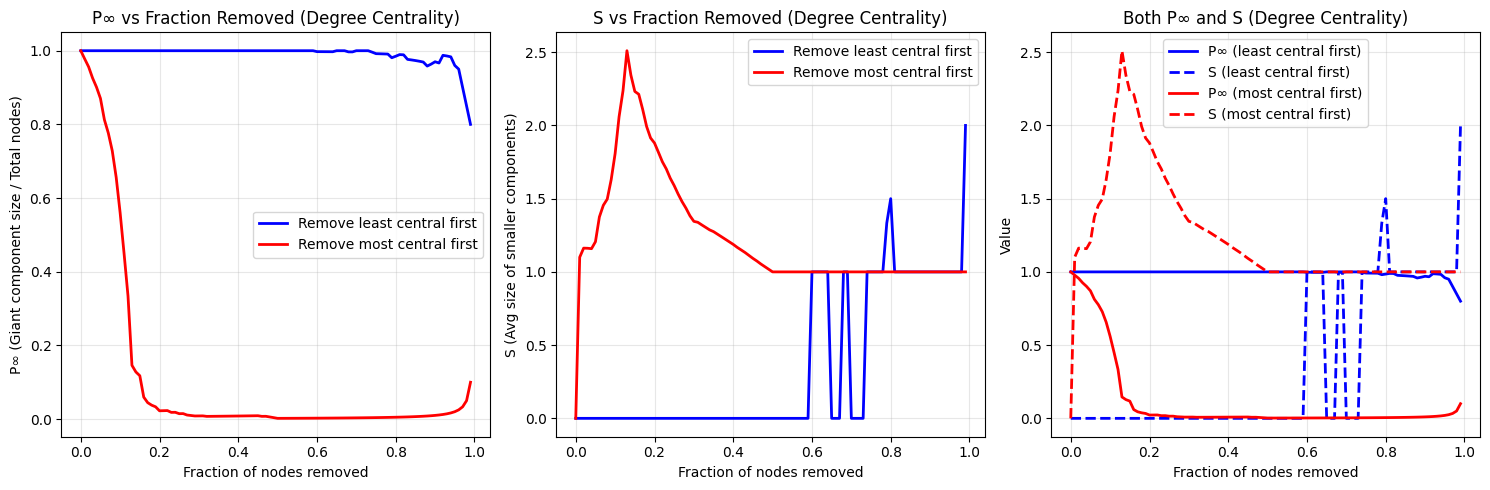

In [10]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least central first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most central first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Degree Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least central first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most central first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Degree Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least central first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least central first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most central first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most central first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Degree Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Remove nodes by betweeness centrality (ascending = least central first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, betweenness_centrality, ascending=True)

# Remove nodes by betweeness centrality (descending = most central first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, betweenness_centrality, ascending=False)

In [12]:
for i, j in zip(fractions_asc, S_asc):
    print(i, j)



0.0 0
0.01 0
0.02 0
0.03 0
0.04 0
0.05 0
0.06 0
0.07 0
0.08 0
0.09 0
0.1 0
0.11 0
0.12 0
0.13 0
0.14 0
0.15 0
0.16 0
0.17 0
0.18 0
0.19 0
0.2 0
0.21 0
0.22 0
0.23 0
0.24 0
0.25 0
0.26 0
0.27 0
0.28 0
0.29 0
0.3 0
0.31 0
0.32 0
0.33 0
0.34 0
0.35 0
0.36 0
0.37 0
0.38 0
0.39 0
0.4 0
0.41 0
0.42 0
0.43 0
0.44 0
0.45 0
0.46 0
0.47 0
0.48 0
0.49 0
0.5 0
0.51 0
0.52 0
0.53 0
0.54 0
0.55 0
0.56 0
0.57 0
0.58 0
0.59 0
0.6 0
0.61 0
0.62 0
0.63 0
0.64 0
0.65 0
0.66 0
0.67 0
0.68 0
0.69 0
0.7 0
0.71 0
0.72 0
0.73 0
0.74 0
0.75 0
0.76 0
0.77 0
0.78 0
0.79 0
0.8 0
0.81 0
0.82 0
0.83 0
0.84 0
0.85 1.0
0.86 1.0
0.87 1.0
0.88 1.0
0.89 1.0
0.9 1.0
0.91 1.0
0.92 1.0
0.93 1.0
0.94 0
0.95 0
0.96 1.0
0.97 0
0.98 0
0.99 0


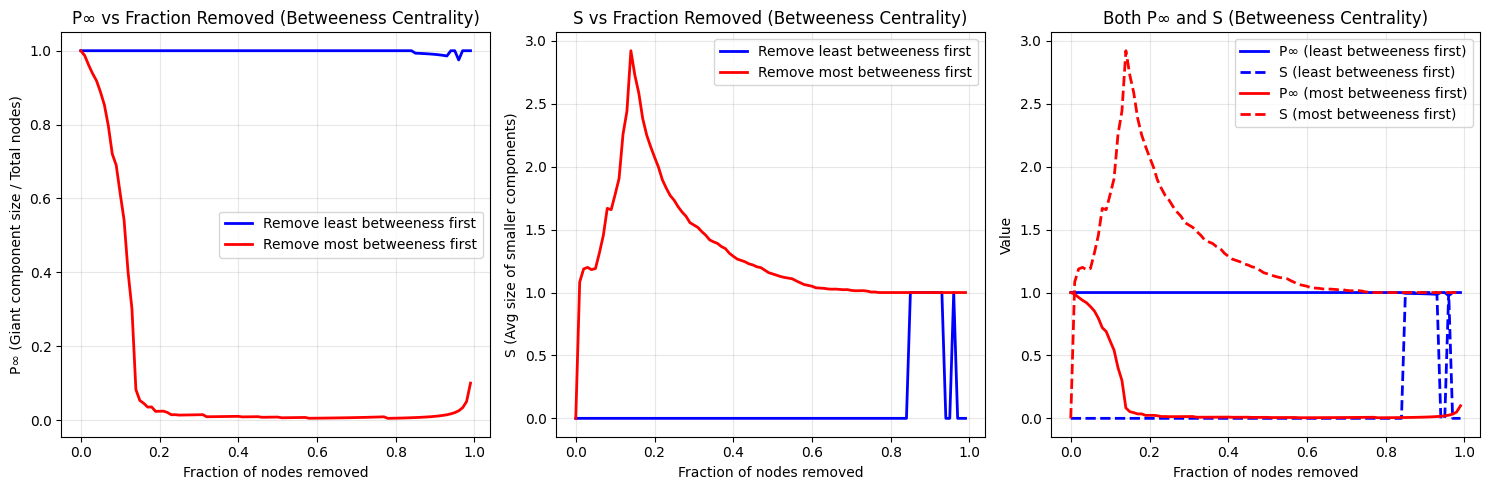

In [13]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least betweeness first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most betweeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Betweeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least betweeness first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most betweeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Betweeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least betweeness first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least betweeness first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most betweeness first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most betweeness first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Betweeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Remove nodes by closeness centrality (ascending = least close first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, closeness_centrality, ascending=True)

# Remove nodes by closeness centrality (descending = most close first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, closeness_centrality, ascending=False)

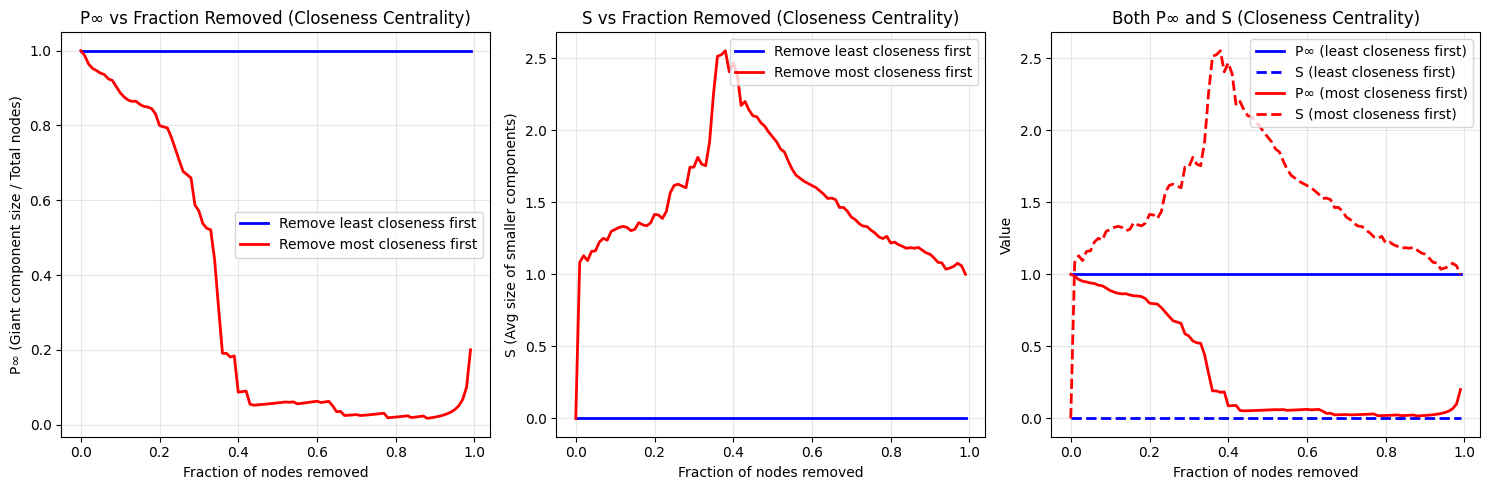

In [15]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least closeness first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most closeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Closeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least closeness first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most closeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Closeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least closeness first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least closeness first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most closeness first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most closeness first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Closeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Remove nodes by closeness centrality (ascending = least close first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, eigenvector_centrality, ascending=True)

# Remove nodes by closeness centrality (descending = most close first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, eigenvector_centrality, ascending=False)

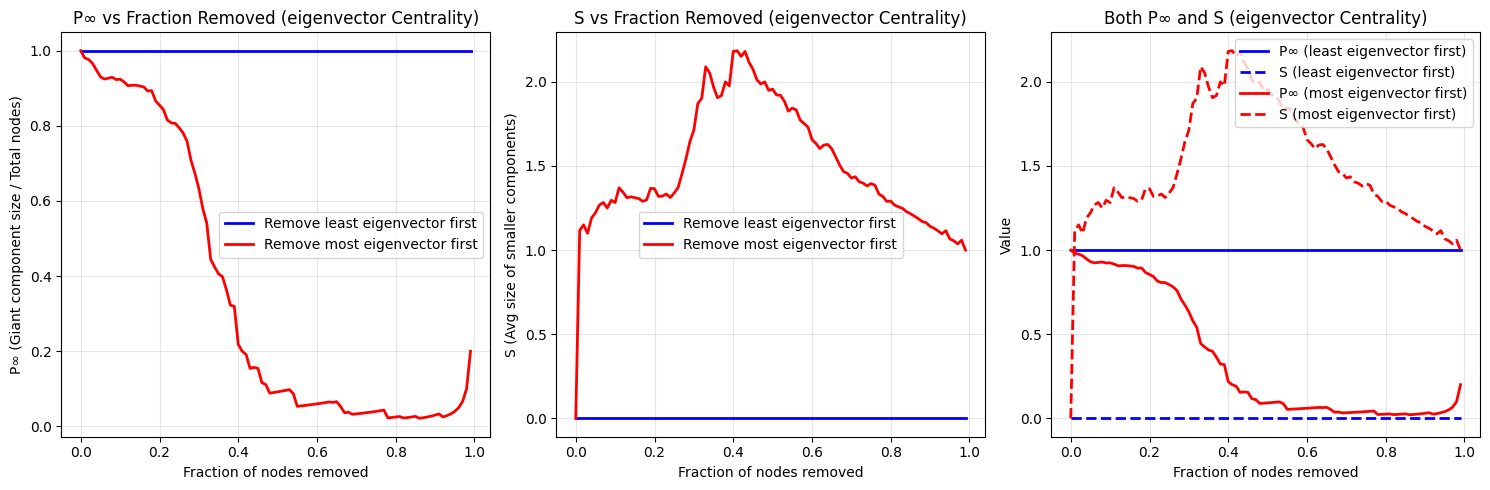

In [17]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least eigenvector first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most eigenvector first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (eigenvector Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least eigenvector first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most eigenvector first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (eigenvector Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least eigenvector first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least eigenvector first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most eigenvector first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most eigenvector first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (eigenvector Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()